In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex
from iexfinance.refdata import get_symbols

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [81]:
# Set the ticker
list_of_tickers = ["SPY", "AGG"]

# Set Start and end date
end_date = datetime.now()
start_date = end_date + timedelta(-365)


# Get 1 year's worth of historical data for TSLA
tickers_df = pd.DataFrame(get_historical_data(list_of_tickers, start_date, end_date, output_format='pandas'))
tickers_df.head()

SPY                                        AGG                  \
              open    high     low   close     volume    open    high     low   
date                                                                            
2018-10-01  292.11  292.93  290.98  291.73   62078937  105.35  105.35  105.20   
2018-10-02  291.56  292.36  291.14  291.56   47258227  105.32  105.46  105.25   
2018-10-03  292.74  293.21  291.32  291.72   64694594  105.22  105.24  104.75   
2018-10-04  291.18  291.24  287.66  289.44  111545910  104.65  104.72  104.47   
2018-10-05  289.69  290.27  286.22  287.82  105951698  104.46  104.48  104.19   

                             
             close   volume  
date                         
2018-10-01  105.24  3517615  
2018-10-02  105.36  6912595  
2018-10-03  104.86  2540483  
2018-10-04  104.56  5268197  
2018-10-05  104.33  3460512

In [84]:
# Use the `drop` function to drop extra columns in the DataFrame
tickers_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
tickers_df.head()

,SPY,AGG
,close,close
date,,
2018-10-01,291.73,105.24
2018-10-02,291.56,105.36
2018-10-03,291.72,104.86
2018-10-04,289.44,104.56
2018-10-05,287.82,104.33


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 20 years

In [6]:
# Calculate the daily roi for the stocks
daily_returns = tickers_df.pct_change()
daily_returns.head()

,SPY,AGG
,close,close
date,,
2018-10-01,NaN,NaN
2018-10-02,-0.000583,0.001140
2018-10-03,0.000549,-0.004746
2018-10-04,-0.007816,-0.002861
2018-10-05,-0.005597,-0.002200


In [8]:
# Calculate volatility
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg

0.000292545882004136

In [17]:
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.0019596660724796587

In [11]:
# Save the last day's closing price
spy_last_price = tickers_df['SPY']['close'][-1]
agg_last_price = tickers_df['AGG']['close'][-1]


In [92]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

monte_carlo = pd.DataFrame()
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the Monte Carlo Simulation
for n in range(number_simulations):
   # Initialize the simulated prices list with the last closing price of `TSLA` and `SPHD`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005749,1.009593,1.004254,1.008469,1.009880,1.001492,0.988616,0.991219,1.000920,1.000142,...,0.997309,1.011903,0.995099,0.997039,0.990628,1.005459,1.001072,0.996632,1.007683,0.995166
2,1.010999,1.001342,1.007282,0.999483,1.002328,0.999096,0.993522,0.978906,1.012910,0.994462,...,1.000058,0.996068,0.986174,0.984845,0.996717,1.009323,1.016796,1.000364,1.011775,0.992901
3,1.024330,0.995513,0.997331,0.989304,0.999352,0.999650,1.000981,0.986859,1.011477,0.993775,...,0.999317,0.999496,0.984972,0.999085,0.998617,0.998538,1.013231,1.009352,1.026773,0.994464
4,1.021978,1.002207,1.007251,0.992687,0.999469,1.010365,1.010262,0.985210,1.006150,0.994801,...,1.002032,1.003496,0.976202,0.999825,0.986196,1.001249,1.010843,1.005414,1.021938,1.003509


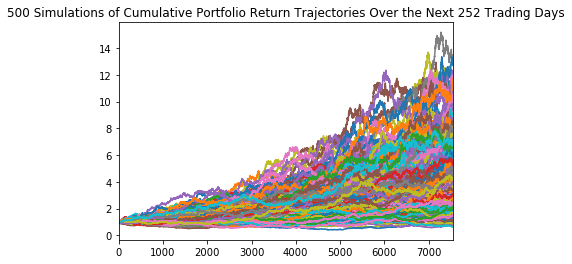

In [93]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [95]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    3.540626
1    3.533390
2    3.071415
3    3.024631
4    5.006140
Name: 7560, dtype: float64

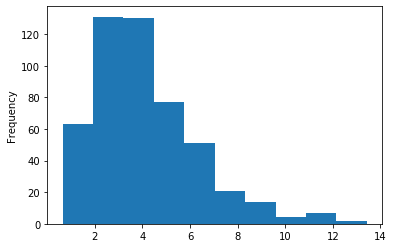

In [96]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind='hist', bins=10)

In [97]:
# Use the `value_counts` function and the `len` function to calculate the probabilities of cumulative return ranges
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(1.925, 3.204]      0.262
(3.204, 4.482]      0.260
(4.482, 5.76]       0.154
(0.633, 1.925]      0.126
(5.76, 7.039]       0.102
(7.039, 8.317]      0.042
(8.317, 9.595]      0.028
(10.874, 12.152]    0.014
(9.595, 10.874]     0.008
(12.152, 13.431]    0.004
Name: 7560, dtype: float64

In [98]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.10, 0.90])
confidence_interval

0.1    1.660710
0.9    7.015592
Name: 7560, dtype: float64

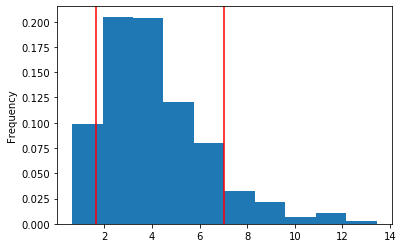

In [99]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [116]:
#expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles

confidence_interval = ending_cumulative_returns.quantile(q=[0.10,.50, 0.90])
confidence_interval

0.1    1.660710
0.5    3.729392
0.9    7.015592
Name: 7560, dtype: float64

In [114]:
#tenth percentile = initial_investment * confidence_interval.iloc[0]



### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [125]:
#Intital Investment at 90th percentile

# Set initial investment
initial_investment = 20000

tenth_percentile = initial_investment * confidence_interval.iloc[0]
fith_percentile = initial_investment * confidence_interval.iloc[1]
nineth_percentile = initial_investment * confidence_interval.iloc[2]

#cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - spy_last_price) / spy_last_price)
#cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - agg_last_price) / agg_last_price)
#
# Add the initial investment to the cumulative profit/loss of lower and upper bound
#ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
#ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

#print("10% quantile =",np.percentile(ending_cumulative_returns,10))
#print("50% quantile =",np.percentile(ending_cumulative_returns,50))
#print("90% quantile =",np.percentile(ending_cumulative_returns,90))

#Print the results
#print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
 #     f" over the next 252 trading days will end within in the range of"
 #     f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

print(f'Expected retunrs at 10th Percentile: {tenth_percentile}')
print(f'Expected retunrs at 50th Percentile: {fith_percentile}')
print(f'Expected retunrs at 90th Percentile: {nineth_percentile}')

Expected retunrs at 10th Percentile: 33214.199309700525
Expected retunrs at 50th Percentile: 74587.84918954172
Expected retunrs at 90th Percentile: 140311.83864399258


In [117]:
#Intital Investment at 10th percentile

# Set initial investment
initial_investment = 20000

cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - spy_last_price) / spy_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - agg_last_price) / agg_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

#Print the results
print(f"There is a 10% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 252 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 10% chance that an initial investment of $20,000 in the portfolio over the next 252 trading days will end within in the range of $173943.1663843847 and $37497.692079560875


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

The four percent withdraw rate will exceed the value at the 10th percentile

In [110]:
answer = (tenth_percentile + initial_investment) * .04

if answer > 6085:
    print(True)
else: 
    print(False)

False


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

A 50% increase would not exceed the value

In [126]:
initial_investment = 20000

tenth_percentile = initial_investment * confidence_interval.iloc[0]
fith_percentile = initial_investment * confidence_interval.iloc[1]
nineth_percentile = initial_investment * confidence_interval.iloc[2]
print(f'Expected retunrs at 10th Percentile: {tenth_percentile}')
print(f'Expected retunrs at 50th Percentile: {fith_percentile}')
print(f'Expected retunrs at 90th Percentile: {nineth_percentile}')

Expected retunrs at 10th Percentile: 33214.199309700525
Expected retunrs at 50th Percentile: 74587.84918954172
Expected retunrs at 90th Percentile: 140311.83864399258


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE